In [1]:
import torch 
import numpy as np 
import random 

def set_seeds(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
set_seeds(0)

## 讀檔

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 讀取資料並標註標籤
df_fake = pd.read_csv('newsData/Fake.csv')['text']
df_real = pd.read_csv('newsData/True.csv')['text']

# 合併資料與標籤
texts = pd.concat([df_fake, df_real], ignore_index=True)
labels = [0] * len(df_fake) + [1] * len(df_real)

# 分割訓練與驗證資料
x_train, x_valid, y_train, y_valid = train_test_split(
    texts.tolist(), labels, train_size=0.8, random_state=46, shuffle=True
)

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 初始化 tokenizer 和模型
model = AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-yelp-polarity")
tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity")

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 創建資料集

In [4]:
from torch.utils.data import Dataset, DataLoader

# 定義 Dataset
class News(Dataset):
    def __init__(self, x, y, tokenizer):
        self.x = x
        self.y = y
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

    def collate_fn(self, batch):    
        (x, y) = zip(*batch)
        x = self.tokenizer(list(x), max_length=512, truncation=True, padding="longest", return_tensors='pt')
        x['labels'] = torch.tensor(y)
        return x



# 初始化 Dataset
trainset = News(x_train, y_train, tokenizer)
validset = News(x_valid, y_valid, tokenizer)

# 初始化 DataLoader
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True, collate_fn=trainset.collate_fn)
valid_loader = DataLoader(validset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True, collate_fn=validset.collate_fn)

Using device: cuda


Valid Epoch 0: 100%|██████████| 281/281 [00:30<00:00,  9.07it/s, loss=0.001]


Saving Model With Loss 0.00152
Train Loss: 0.06083| Valid Loss: 0.00152| Best Loss: 0.00152



Valid Epoch 1: 100%|██████████| 281/281 [00:30<00:00,  9.22it/s, loss=0.295]


Train Loss: 0.13325| Valid Loss: 0.49360| Best Loss: 0.00152



Valid Epoch 2: 100%|██████████| 281/281 [00:30<00:00,  9.24it/s, loss=0.295]


Train Loss: 0.61611| Valid Loss: 0.50382| Best Loss: 0.00152



Valid Epoch 3: 100%|██████████| 281/281 [00:30<00:00,  9.21it/s, loss=0.562]


Train Loss: 0.46823| Valid Loss: 1.38150| Best Loss: 0.00152



Valid Epoch 4: 100%|██████████| 281/281 [00:30<00:00,  9.19it/s, loss=0.688]


Train Loss: 0.56431| Valid Loss: 0.69376| Best Loss: 0.00152



Valid Epoch 5: 100%|██████████| 281/281 [00:30<00:00,  9.21it/s, loss=0.688]


Train Loss: 0.69605| Valid Loss: 0.69469| Best Loss: 0.00152

------------------------------------
|Model can't improve, stop training|
------------------------------------


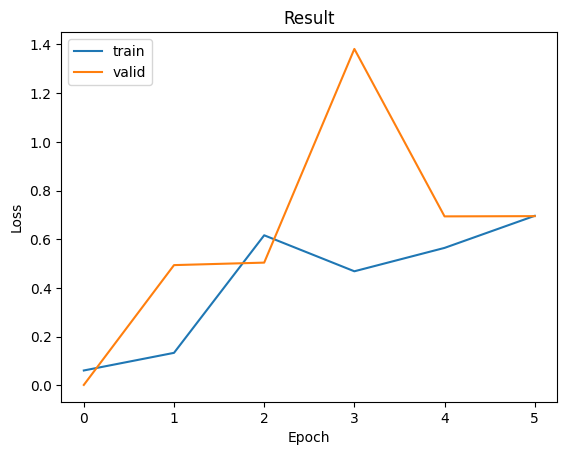

Best model loaded from ./checkpoints\best_model.ckpt


In [5]:
from Trainer import Trainer
import torch.optim as optim
from transformers import get_cosine_schedule_with_warmup

# 總步數 = epoch 數 * 每個 epoch 的 batch 數
num_training_steps = len(train_loader) * 100  # 100 是總 epoch 數
num_warmup_steps = int(0.2 * len(train_loader))  # 可調整 warmup 比例

optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)
trainer = Trainer(
    epochs=100,
    train_loader=train_loader,
    valid_loader=valid_loader,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    early_stopping=5,
    load_best_model=True,
    grad_clip=1.0,
)

trainer.train(show_loss=True)

Evaluating: 100%|██████████| 281/281 [00:30<00:00,  9.16it/s]


              precision    recall  f1-score   support

        fake     1.0000    0.9998    0.9999      4620
        real     0.9998    1.0000    0.9999      4360

    accuracy                         0.9999      8980
   macro avg     0.9999    0.9999    0.9999      8980
weighted avg     0.9999    0.9999    0.9999      8980



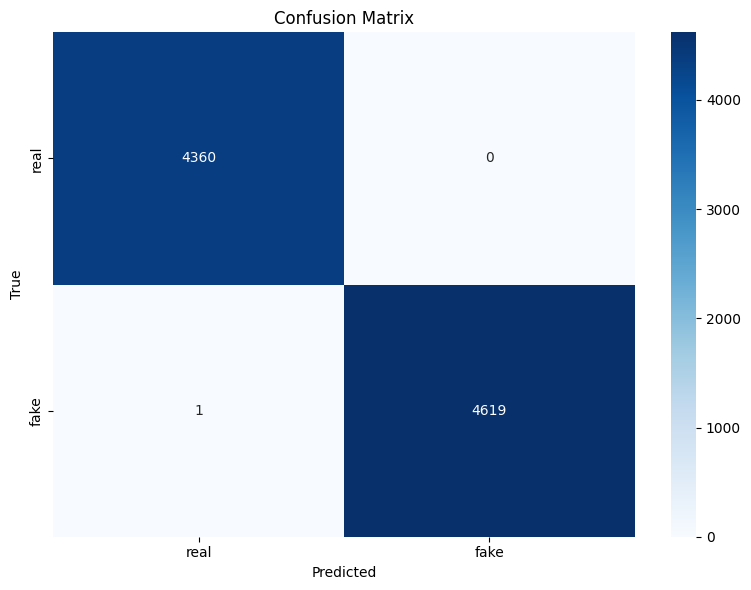

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader, label_decoding, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    all_preds, all_labels = [], []
    for batch in tqdm(data_loader, desc='Evaluating'):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.tolist())
        all_labels.extend(batch['labels'].tolist())

    # 解碼標籤
    decoded_labels = [label_decoding[l] for l in all_labels]
    decoded_preds = [label_decoding[p] for p in all_preds]

    # 顯示分類報告
    print(classification_report(decoded_labels, decoded_preds, digits=4, zero_division=0))

    # 繪製混淆矩陣
    cm = confusion_matrix(decoded_labels, decoded_preds, labels=list(label_decoding.values()))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_decoding.values(),
                yticklabels=label_decoding.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

label_decoding = {1: 'real', 0: 'fake'}
evaluate_model(model, valid_loader, label_decoding)